In [4]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL

import collections
import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage
from torchvision.utils import make_grid
import torch.nn.functional as F


device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [13]:
def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, mask

def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict

def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars


def render_points(points, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    colors = [[1,0,0,1], [0,1,0,1], [0,0,1,1]]
    all_points = 0.5 * (points + 1.0) * canvas_size
    print("all_points", all_points.max(), all_points.min())
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        width = torch.tensor(1.0)
        if widths is not None:
            width = widths[p]
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=width, is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor(colors[p]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img


torch.Size([3, 6])
tensor([[0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')
tensor([1., 1., 1., 1., 2., 0.], device='cuda:0')
tensor([[0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], device='cuda:0')
tensor([2., 1., 0., 2., 1., 0.], device='cuda:0')
torch.Size([1, 3, 4, 2])
all_points tensor(224., device='cuda:0') tensor(0., device='cuda:0')


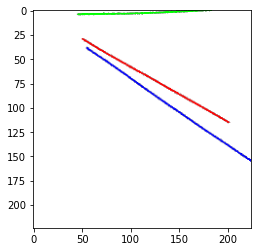

points_vars torch.Size([1, 3, 4, 2])
lefts torch.Size([1, 3, 2])
edge_points torch.Size([1, 6, 2])
connect torch.Size([1, 6, 6])
new_edge_points torch.Size([1, 6, 2])
all_points tensor(192.0913, device='cuda:0') tensor(3.6432, device='cuda:0')


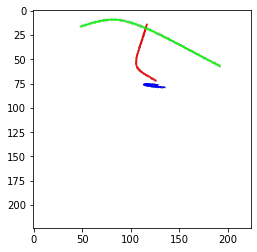

In [21]:
num_strokes=3

n = num_strokes * 2
shift_matrix = torch.rand((n // 2, n))
print(shift_matrix.shape)
g = F.gumbel_softmax(shift_matrix.contiguous() / 1, hard=True)
# print(g)
g_flip = g.flip(0).flip(1)
# print(g_flip)
adj_mat = torch.cat([g, g_flip], dim=0).to(device)
adj_mat = torch.tensor([
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]], device='cuda:0')
print(adj_mat)
print(adj_mat.sum(dim=0))

n = num_strokes * 2
adj_mat = torch.rand((n, n))
adj_mat = F.gumbel_softmax(adj_mat.contiguous() / 1, hard=True).to(device)
# print(g)
# g_flip = g.flip(0).flip(1)
# # print(g_flip)
# adj_mat = torch.cat([g, g_flip], dim=0).to(device)
# adj_mat = torch.tensor([
#         [0., 0., 0., 0., 1., 0.],
#         [0., 0., 0., 1., 0., 0.],
#         [0., 0., 0., 0., 1., 0.],
#         [0., 1., 0., 0., 0., 0.],
#         [1., 0., 1., 0., 0., 0.],
#         [0., 0., 0., 0., 0., 0.]], device='cuda:0')
print(adj_mat)
print(adj_mat.sum(dim=0))

random.seed(2)
np.random.seed(2)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(2)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"

device = torch.device("cuda" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
canvas_size=224

num_cp=4

target, mask = get_target(target_, device, image_scale=224)

points_vars = get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224)

points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
points_vars[:,:,0,:] = points_vars[:,:,0,:] / 2
points_vars[:,:,-1,:] = points_vars[:,:,-1,:] * 2
print(points_vars.shape)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()



print("points_vars",points_vars.shape)

lefts = points_vars[:,:,0,:]
print("lefts",lefts.shape)
edge_points = torch.cat([points_vars[:,:,0,:], points_vars[:,:,-1,:]], dim=1)
print("edge_points", edge_points.shape)

connect = torch.eye(num_strokes * 2, num_strokes * 2).unsqueeze(0).to(device)
# connect[0,0,0] = 0
# connect[0,0,0] = 1
print("connect", connect.shape)

new_edge_points = (torch.matmul(adj_mat, edge_points) + edge_points) / (adj_mat.sum(dim=1).unsqueeze(0).unsqueeze(-1) + 1)
print("new_edge_points", new_edge_points.shape)

points_vars[:,:,0,:] = new_edge_points[:,:num_strokes,:]
points_vars[:,:,-1,:] = new_edge_points[:,num_strokes:,:]
# y_ = torch.matmul(connect, points_vars[:,:,:,1])
# print("x_", x_.shape)
# points_vars = torch.cat([x_,y_], dim=0).permute(1,2,0).unsqueeze(0)
# print(torch.eq(res, points_vars))

widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()

torch.Size([1, 3, 4, 2])
all_points tensor(224., device='cuda:0') tensor(0., device='cuda:0')


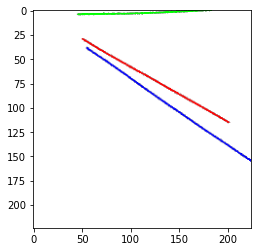

edge_points torch.Size([1, 6, 2])
distances
torch.Size([1, 6, 6])
tensor([[[0.0000, 0.2323, 0.0907, 1.5436, 1.2101, 1.9063],
         [0.2323, 0.0000, 0.3203, 1.7014, 1.2216, 2.0793],
         [0.0907, 0.3203, 0.0000, 1.4690, 1.1916, 1.8264],
         [1.5436, 1.7014, 1.4690, 0.0000, 1.0423, 0.4068],
         [1.2101, 1.2216, 1.1916, 1.0423, 0.0000, 1.4290],
         [1.9063, 2.0793, 1.8264, 0.4068, 1.4290, 0.0000]]], device='cuda:0')
tensor([[0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0.]], device='cuda:0')
all_points tensor(203.5413, device='cuda:0') tensor(3.6432, device='cuda:0')


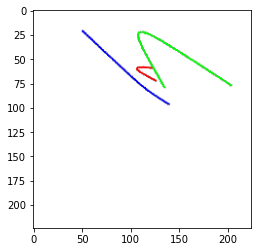

In [26]:
num_strokes=3
canvas_size=224
num_cp=4

random.seed(2)
np.random.seed(2)
# os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(2)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"
target, mask = get_target(target_, device, image_scale=224)
points_vars = get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224)

points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
points_vars[:,:,0,:] = points_vars[:,:,0,:] / 2
points_vars[:,:,-1,:] = points_vars[:,:,-1,:] * 2
print(points_vars.shape)
points_vars = (points_vars - points_vars.min()) / (points_vars.max() - points_vars.min())
points_vars = 2*points_vars-1

widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()


edge_points = torch.cat([points_vars[:,:,0,:], points_vars[:,:,-1,:]], dim=1)
print("edge_points", edge_points.shape)

distances = torch.cdist(edge_points, edge_points, p=2)
print("distances")
print(distances.shape)
print(distances)
adj_mat = F.gumbel_softmax(distances.contiguous() / 1, hard=True).to(device).squeeze(0)
print(adj_mat)
# n = num_strokes * 2
# adj_mat = torch.rand((n, n))
# adj_mat = F.gumbel_softmax(adj_mat.contiguous() / 1, hard=True).to(device)
# print(adj_mat)
# print(adj_mat.sum(dim=0))


# connect = torch.eye(num_strokes * 2, num_strokes * 2).unsqueeze(0).to(device)
# # connect[0,0,0] = 0
# # connect[0,0,0] = 1
# print("connect", connect.shape)

new_edge_points = (torch.matmul(adj_mat, edge_points) + edge_points) / (adj_mat.sum(dim=1).unsqueeze(0).unsqueeze(-1) + 1)
# print("new_edge_points", new_edge_points.shape)

points_vars[:,:,0,:] = new_edge_points[:,:num_strokes,:]
points_vars[:,:,-1,:] = new_edge_points[:,num_strokes:,:]
# # y_ = torch.matmul(connect, points_vars[:,:,:,1])
# # print("x_", x_.shape)
# # points_vars = torch.cat([x_,y_], dim=0).permute(1,2,0).unsqueeze(0)
# # print(torch.eq(res, points_vars))

widths = torch.ones((num_strokes)).to(device)
im = render_points(points_vars, widths, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224)
plt.imshow(im.cpu().numpy())
plt.show()